In [34]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import supervision as sv

In [35]:
def load_dataset(segments_folder):
    dataset_information = []   
    for video in os.listdir(segments_folder):
        path = os.path.join(segments_folder, video)
        size = os.path.getsize(path)
        try:
            vi = sv.VideoInfo.from_video_path(path)
            dataset_information.append({
                'width': vi.width, 'height':vi.width, 'fps':vi.fps, 'total_frames':vi.total_frames, 'path':path, 'size':size
            })
        except:
            print(f'Could not open {path}')
    print(len(dataset_information))
    return pd.DataFrame(dataset_information)

df = load_dataset("segments_folder")


917


In [36]:
df.head(10)
print(len(df))

917


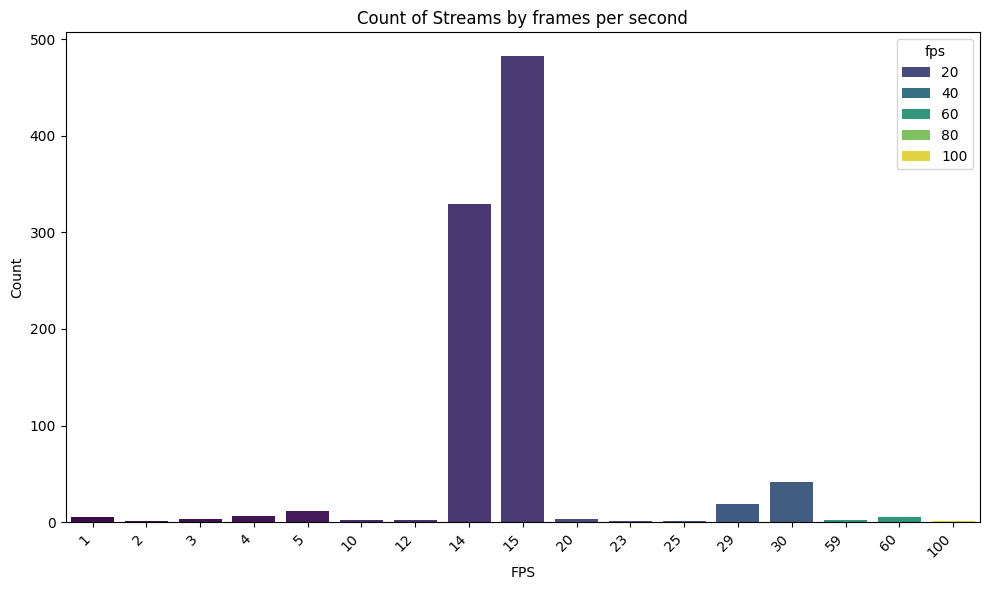

In [37]:
# Count the occurrences of each unique FPS value
fps_counts = df['fps'].value_counts().sort_index()

# Create a count plot using seaborn for FPS
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='fps', order=fps_counts.index, palette='viridis', hue='fps')

plt.xlabel('FPS')
plt.ylabel('Count')
plt.title('Count of Streams by frames per second')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

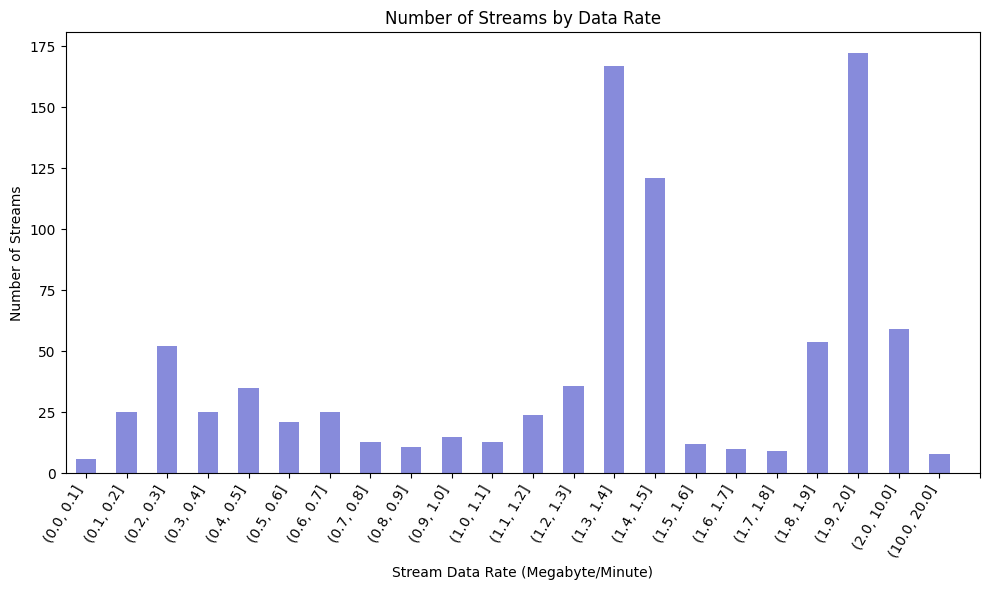

In [38]:
# Calculate size in megabytes
df['size_mb'] = df['size'] * 6 / (1024 ** 2)  # 1024 bytes = 1 kilobyte, 1024 kilobytes = 1 megabyte

# Create bins based on your specifications
bins = [i / 10 for i in range(21)] + [i for i in range(10, 30, 10)]

# Cut the data into these bins
df['bin'] = pd.cut(df['size_mb'], bins=bins)

# Count the number of videos in each bin
video_count_by_bin = df['bin'].value_counts().sort_index()

# Create a bar plot for video counts by bin
plt.figure(figsize=(10, 6))
ax = video_count_by_bin.plot(kind='bar', color='#878bdb')
ax.set_xticks(range(len(bins)))
plt.xlabel('Stream Data Rate (Megabyte/Minute)')
plt.ylabel('Number of Streams')
plt.title('Number of Streams by Data Rate')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


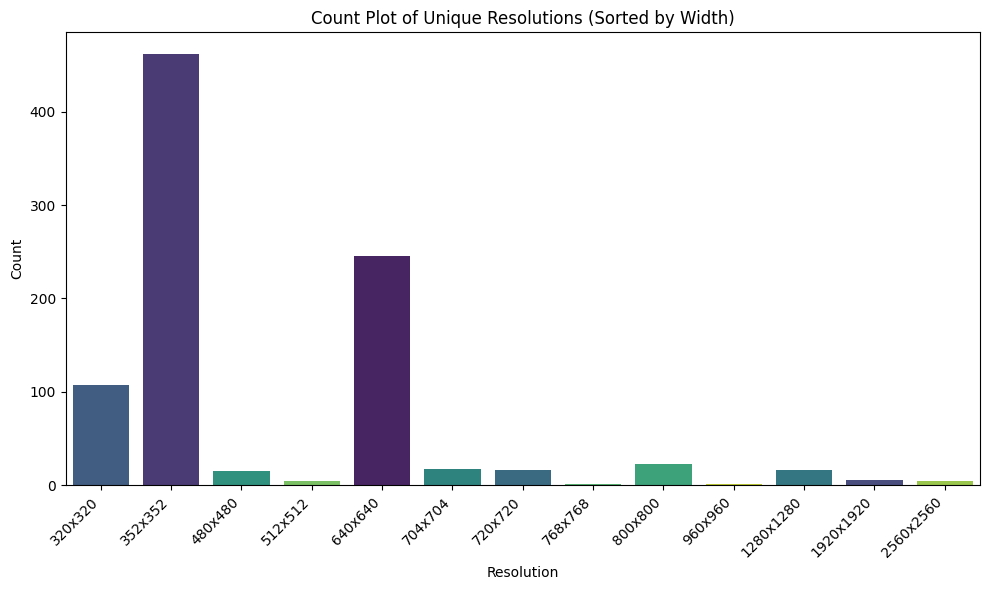

In [39]:
# Calculate the widths of each resolution
df['resolution_width'] = df['width'].astype(int)  # Convert width column to integer type
df['resolution'] = df['width'].astype(str) + 'x' + df['height'].astype(str)

resolution_widths = df.groupby('resolution')['resolution_width'].max().reset_index()

# Sort resolutions by width in descending order
sorted_resolutions = resolution_widths.sort_values(by='resolution_width', ascending=True)['resolution']

# Count the occurrences of each unique resolution using the sorted order
resolution_counts = df['resolution'].value_counts().loc[sorted_resolutions]

# Create a count plot using seaborn with sorted resolutions
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='resolution', hue='resolution', order=sorted_resolutions, palette='viridis', legend=False)

plt.xlabel('Resolution')
plt.ylabel('Count')
plt.title('Count Plot of Unique Resolutions (Sorted by Width)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [42]:
# Calculate the total pixels per frame
df['total_pixels_per_frame'] = df['width'] * df['height']
# Calculate the total pixels per minute
df['total_pixels_per_minute'] = df['total_pixels_per_frame'] * df['fps'] * 60
# Calculate the megabytes per minute for each row
df['megabytes_per_minute'] = (df['size_mb'] / df['total_frames']) * df['fps'] * 60

# Calculate the total megabytes per minute for the entire system
total_gigabtyes_per_minute = df['megabytes_per_minute'].sum() / 1024
total_pixels_per_minute = df['total_pixels_per_minute'].sum()
total_frames_per_minute = df['fps'].sum() * 60
total_frames_per_day = total_frames_per_minute * 60 * 24

print(f"Total Gigabytes per Minute for the System: {total_gigabtyes_per_minute:.3f}")
print(f"Total Terabytes per Day for the System: {(total_gigabtyes_per_minute * 60 * 24 / 1024):.3f}")
print(f"Total pixels per Day for the System: {(total_pixels_per_minute * 60 * 24 / 10**12):.3f} trillion")
print(f"Frames per minute: {total_frames_per_minute}")
print(f"Total frames per day: {total_frames_per_day}")
# print(df.head())

Total Gigabytes per Minute for the System: 9.805
Total Terabytes per Day for the System: 13.788
Total pixels per Day for the System: 363.175 trillion
Frame per minute: 865920
Total frames per day: 1246924800


In [44]:
cpus = {
    "13th Gen Intel® Core™ i5-1340P": {
        'cores': 8,
        'inference_time': 33.03,
        'price': 300

    },
    "13th Gen Intel® Core™ i7-13700F": {
        'cores': 16,
        'inference_time': 66.63,
        'price': 336.75
    },
    "Intel ® Xeon ® Platinum 8480+": {
        'cores': 56,
        'inference_time': 5.99,
        'price': 12853.00
    },
    "NVIDIA A100": {
        'cores': 30,
        'inference_time': 1,
        'price': 27671.00
    }
}
def calculate_cpus_needed(cpus, total_frames_per_minute):
    cpu_requirements = {}

    for cpu, details in cpus.items():
        cores = details['cores']
        inference_time = details['inference_time']
        
        # Calculate frames processed per minute by one core
        frames_per_core_per_minute = 60000  / inference_time
        
        # Calculate total frames processed per minute by all cores
        total_frames_per_minute_by_cores = cores * frames_per_core_per_minute
        
        # Calculate the number of CPUs needed
        cpus_needed = total_frames_per_minute / total_frames_per_minute_by_cores
        
        cpu_requirements[cpu] = cpus_needed

    return cpu_requirements
    
cpu_requirements = calculate_cpus_needed(cpus, total_frames_per_minute)
for cpu, cpus_needed in cpu_requirements.items():
    print(f"For CPU '{cpu}', {cpus_needed:.2f} CPUs are needed at a price of ${cpus_needed*cpus[cpu]['price']:.2f}")

For CPU '13th Gen Intel® Core™ i5-1340P', 59.59 CPUs are needed at a price of $17875.84
For CPU '13th Gen Intel® Core™ i7-13700F', 60.10 CPUs are needed at a price of $20238.76
For CPU 'Intel ® Xeon ® Platinum 8480+', 1.54 CPUs are needed at a price of $19841.29
For CPU 'NVIDIA A100', 0.48 CPUs are needed at a price of $13311.60


In [ ]:
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model
if not os.path.isdir('yolov8n_openvino_model/'):
    model.export(format='openvino') 
    ov_model = YOLO('yolov8n_openvino_model/', task="detect")


In [5]:
results = model.track('segments_folder\stream_0_segment_000.mp4', persist=True, save=True, project='/results')
print(df.head())

   width  height  fps  total_frames  \
0    640     640   14           900   
1    640     640   14           900   
2    640     640   14           898   
3    640     640   14           900   
4    640     640   14           898   

                                        path     size  
0   segments_folder\stream_0_segment_000.mp4  1454565  
1  segments_folder\stream_10_segment_000.mp4  1453197  
2  segments_folder\stream_11_segment_000.mp4  1461163  
3  segments_folder\stream_12_segment_000.mp4  1438691  
4  segments_folder\stream_13_segment_000.mp4  1444254  


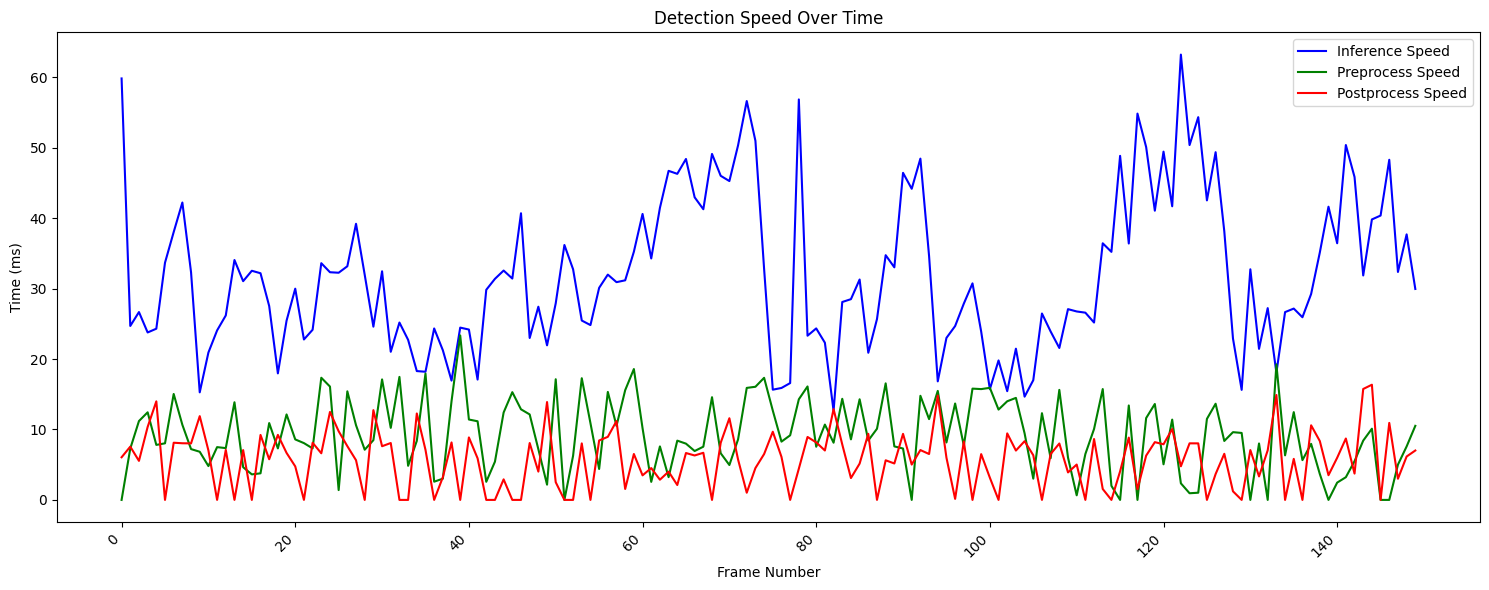

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a list of results objects and you want to plot their speeds
# Replace 'results' with your actual list of results

# Extract speeds from the results objects
preprocess_speeds = [result.speed['preprocess'] for result in results]
inference_speeds = [result.speed['inference'] for result in results]
postprocess_speeds = [result.speed['postprocess'] for result in results]

# Create a count plot of speeds with indices on the x-axis
plt.figure(figsize=(15, 6))  # Adjust the figure size for better visualization

# Plot the inference speeds in blue
sns.lineplot(x=range(len(inference_speeds)), y=inference_speeds, color='blue', label='Inference Speed')

# Plot the preprocess speeds in green
sns.lineplot(x=range(len(preprocess_speeds)), y=preprocess_speeds, color='green', label='Preprocess Speed')

# Plot the postprocess speeds in red
sns.lineplot(x=range(len(postprocess_speeds)), y=postprocess_speeds, color='red', label='Postprocess Speed')

plt.xlabel('Frame Number')
plt.ylabel('Time (ms)')
plt.title('Detection Speed Over Time')
plt.legend()  # Show legend with labels for each line

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [272]:
import threading
from ultralytics import YOLO
import cv2


def inference_thread(video_file, model_path, thread_index):
    """
    Runs inference on a video file concurrently with the YOLOv8 model using threading.

    Args:
        video_file (str): The path to the video file.
        model_path (str): The path to the YOLOv8 model checkpoint.
        thread_index (int): An index to uniquely identify the thread, used for display purposes.
    """
    # Load a separate YOLO model instance for this thread
    model = YOLO(model_path)
    print(f"Thread {thread_index} starting")
    video = cv2.VideoCapture(video_file)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_file = f'output_thread_{thread_index}.mp4'
    fps = int(video.get(cv2.CAP_PROP_FPS))
    frame_size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

    while True:
        ret, frame = video.read()  # Read video frames
        if not ret:
            break
        results = model.track(frame, persist=True, save=True, project='/results')
        tracked_frame = results[0].plot()
        out.write(tracked_frame)
    video.release()
    out.release()

def run_inference_concurrently(num_threads, video_files, model_paths):
    """
    Runs inference concurrently on multiple videos using multiple threads.

    Args:
        num_threads (int): Number of threads to run concurrently.
        video_files (list): List of paths to video files.
        model_paths (list): List of paths to YOLOv8 model checkpoints.
    """
    threads = []

    for i in range(num_threads):
        video_file = video_files[i]  # Get the video file path
        model_path = model_paths[i % len(model_paths)]  # Cycle through model paths

        # Create and start a new inference thread
        thread = threading.Thread(target=inference_thread, args=(video_file, model_path, i), daemon=True)
        threads.append(thread)
        thread.start()

    # Wait for all threads to finish
    for thread in threads:
        thread.join()

# Example usage:
num_threads = 8  # Specify the number of threads
video_files = [f'segments_folder\stream_{i}_segment_000.mp4' for i in range(0,num_threads)]
model_paths = ['yolov8n.pt', 'yolov8s_openvino_model/']  # Specify the YOLO model checkpoints
run_inference_concurrently(num_threads, video_files, model_paths)


WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.
WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.
WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.
WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.


Thread 1 starting
Thread 3 starting
Thread 5 starting
Thread 7 starting
Thread 6 starting
Thread 2 starting
Thread 0 starting
Thread 4 starting


Loading yolov8s_openvino_model for OpenVINO inference...
Loading yolov8s_openvino_model for OpenVINO inference...
Loading yolov8s_openvino_model for OpenVINO inference...
Loading yolov8s_openvino_model for OpenVINO inference...








0: 480x640 4 cars, 1 train, 1392.4ms
Speed: 4.9ms preprocess, 1392.4ms inference, 15.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to \results\predict873

0: 480x640 12 cars, 1 truck, 1368.6ms
Speed: 67.6ms preprocess, 1368.6ms inference, 16.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to \results\predict873
0: 480x640 9 cars, 1 traffic light, 1243.6ms
Speed: 56.7ms preprocess, 1243.6ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to \results\predict873
0: 480x640 5 cars, 1089.9ms
Speed: 86.3ms preprocess, 1089.9ms inference, 34.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to \results\predict873



0: 480x640 3 cars, 1 train, 1081.2ms
Speed: 8.9ms preprocess,

In [372]:
for i in range(len(df2.path)):
    video = df2.loc[i]['path']
    # print(os.path.exists(video))
    results = ov_model.track(video, persist=True, save=True)
    average_speed = get_average_speed(results)
    for key in average_speed:
        df2.loc[i][key] = average_speed[key]



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_000.mp4: 640x640 9 cars, 1 bus, 1 truck, 29.9ms


True


video 1/1 (2/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_000.mp4: 640x640 4 cars, 1 bus, 117.8ms
video 1/1 (3/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_000.mp4: 640x640 5 cars, 2 buss, 33.0ms
video 1/1 (4/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_000.mp4: 640x640 4 cars, 28.6ms
video 1/1 (5/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_000.mp4: 640x640 3 cars, 1 bus, 31.8ms
video 1/1 (6/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_000.mp4: 640x640 4 cars, 1 bus, 34.6ms
video 1/1 (7/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_000.mp4: 640x640 5 cars, 1 bus, 31.9ms
video 1/1 (8/150) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder_10_seconds\stream_0_segment_0

True


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\video\src\lkpyramid.cpp:1394: error: (-215:Assertion failed) prevPyr[level * lvlStep1].size() == nextPyr[level * lvlStep2].size() in function 'cv::`anonymous-namespace'::SparsePyrLKOpticalFlowImpl::calc'


In [374]:
ov_model.track('segments_folder/stream_222_segment_000.mp4', persist=True, save=True, project='/results')
# os.path.exists(df2.loc[1]['path'])



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/900) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder\stream_222_segment_000.mp4: 640x640 22 cars, 6 trucks, 1 boat, 1 traffic light, 42.6ms
video 1/1 (2/900) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder\stream_222_segment_000.mp4: 640x640 1 car, 35.2ms
video 1/1 (3/900) C:\Users\Julian\Documents\CE 290I\Final Project\segments_folder\stream_222_segment_000.mp4: 640x640 1 car, 25.1ms
video 1/1 (4/900) C:\User

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

width                                                  352
height                                                 352
fps                                                     15
total_frames                                           900
path            segments_folder\stream_949_segment_000.mp4
size                                               1993398
Name: 900, dtype: object